# Optical Coherence Tomography Image Database Images

## **Downloading Dataset**

In [0]:
!ls

'AADD6C6By8TTkjxv6zTg3Nw6a?dl=0'   Diabeticretinopathy	 Normal
 AMD				   flowers		 __pycache__
 AMD.zip			   gdrive.py		 sample_data
 AMD.zip.1			   __MACOSX		 Serousretinopathy
 checkpoints			   Macularhole		 sutils.py


Download AMD dataset from dropbox.

In [0]:
!wget -qq https://www.dropbox.com/s/bd6g661ns39kvjf/AMD.zip
  
!unzip -qq AMD.zip
!rm AMD.zip
!rm -r __MACOSX


Download Macular Hole dataset from dropbox.

In [0]:
!wget -qq https://www.dropbox.com/s/i7yorkoyi7aiix9/Macularhole.zip
  
!unzip -qq Macularhole.zip
!rm Macularhole.zip
!rm -r __MACOSX

Download Normal dataset from dropbox.

In [0]:
!wget -qq https://www.dropbox.com/s/s3ujtskt2s57ao2/Normal.zip
  
!unzip -qq Normal.zip
!rm Normal.zip
!rm -r __MACOSX

Download Serous Retinopathy dataset from dropbox.

In [0]:
!wget -qq https://www.dropbox.com/s/9dumbu71udip8jv/Serousretinopathy.zip
  
!unzip -qq Serousretinopathy.zip
!rm Serousretinopathy.zip
!rm -r __MACOSX

Download diabetic retinopathy dataset from dropbox.

In [0]:
!wget -qq https://www.dropbox.com/s/4w4pige9ypo0lh3/Diabeticretinopathy.zip
  
!unzip -qq Diabeticretinopathy.zip
!rm Diabeticretinopathy.zip
!rm -r __MACOSX

In [0]:
!ls

'AADD6C6By8TTkjxv6zTg3Nw6a?dl=0'   AMD.zip.1		 Normal
 AMD				   Diabeticretinopathy	 sample_data
 AMD.zip			   Macularhole		 Serousretinopathy


## **Testing for GPU**

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Downloading Libraries**

In [0]:

%matplotlib inline
import matplotlib.pyplot as ply

import os, json
from glob import glob

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

import tensorflow as tf

# tf.enable_eager_execution()


In [0]:
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
1.13.0-rc0


# Converting raw files in folders into something that can be feed into tf.data

In [0]:
import glob
import pandas as pd

# bring in the file names 
AMD_filenames = glob.glob('./AMD/*.jpeg')
DR_filenames = glob.glob('./Diabeticretinopathy/*.jpeg')
MH_filenames = glob.glob('./Macularhole/*.jpeg')
Normal_filenames = glob.glob('./Normal/*.jpeg')
SR_filenames = glob.glob('./Serousretinopathy/*.jpeg')

names = ['AMD', 'Diabetic','Macularhole','Normal','Serous']


len(SR_filenames)

102

In [0]:
# directory files 
SR_filenames[:5]

['./Serousretinopathy/CSR26.jpeg',
 './Serousretinopathy/CSR24.jpeg',
 './Serousretinopathy/CSR76.jpeg',
 './Serousretinopathy/CSR2.jpeg',
 './Serousretinopathy/CSR28.jpeg']

In [0]:
# Make a dataframe based on the filenames
df = pd.DataFrame(AMD_filenames, columns = ["filename"])
df2 = pd.DataFrame(DR_filenames, columns = ["filename"])
df3 = pd.DataFrame(MH_filenames, columns = ["filename"])
df4 = pd.DataFrame(Normal_filenames, columns = ["filename"])
df5 = pd.DataFrame(SR_filenames, columns = ["filename"])

# List comprehension
# Add Class columns 
# for all the ones in df.index, place 0
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([3 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([4 for x in range(len(df5.index))], index=df5.index)

df.head()

,filename,class
0,./AMD/AMRD13.jpeg,0
1,./AMD/AMRD19.jpeg,0
2,./AMD/AMRD36.jpeg,0
3,./AMD/AMRD50.jpeg,0
4,./AMD/AMRD37.jpeg,0


In [0]:
# Split into train and validation sets
train_set_percentage = .7

train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]

df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, train_df5])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5])

In [0]:
# shuffle dataframe in place and reset the index 
# specifying drop=True prevents .reset_index from creating column containing old index entries

df_shuffled = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

df_shuffled.head()


,filename,class
0,./Normal/NORMAL173.jpeg,3
1,./Normal/NORMAL61.jpeg,3
2,./Normal/NORMAL204.jpeg,3
3,./Macularhole/MH8.jpeg,2
4,./Diabeticretinopathy/DR20.jpeg,1


3    144
1     74
4     71
2     71
0     38
Name: class, dtype: int64


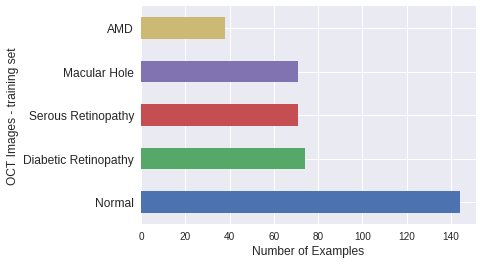

In [0]:
print(df_shuffled['class'].value_counts())

ax = df_shuffled['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("OCT Images - training set", fontsize=12)
ax.set_yticklabels(['Normal','Diabetic Retinopathy','Serous Retinopathy','Macular Hole','AMD'], rotation=0, fontsize=12)
ply.show()

In [0]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df_shuffled["filename"].tolist()
train_labels_list = df_shuffled["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 5

shape_shuffled= df_shuffled.shape[0]
shape_val=df_val.shape[0]



398


# Make the Pipeline for Loading and Resizing Images

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224

# decodes the filename as a jpg file and then resize the images 
def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize_images(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)


## Assembling the Data Pipeline using tf.data

In [0]:
batch_size=32
epochs=5

# tf.data makes tensor of filenames and labels 
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# map into parse function
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat()

train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))

# map into parse function
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.repeat(100)
test_dataset = test_dataset.batch(32)

Download the VGG network weights

In [0]:
# create the base pre-trained model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [0]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 5 classes
predictions = Dense(5, activation='softmax')(x)


In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers

#using the first part of the model as a feature extractor
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_3
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d_3
True
dense_6
True
dropout_3
True
dense_7
True


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

## Add Callbacks

In [0]:
!mkdir checkpoints


checkpoint = ModelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

mkdir: cannot create directory ‘checkpoints’: File exists


In [0]:
train_steps = int(shape_shuffled/32) #total trains set / batch_size, this is equal to one epoch
val_steps = int(shape_val/32)
epochs = 10

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 12
val steps: 5


In [0]:
# # # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps, callbacks=[checkpoint])

Epoch 1/10
11/12 [==========================>...] - ETA: 0s - loss: 0.3814 - acc: 0.8636
Epoch 00001: val_loss improved from inf to 0.36559, saving model to ./checkpoints/weights_01_0.86.hdf5
12/12 [==============================] - 9s 713ms/step - loss: 0.3995 - acc: 0.8646 - val_loss: 0.3656 - val_acc: 0.8562
Epoch 2/10
11/12 [==========================>...] - ETA: 0s - loss: 0.1934 - acc: 0.9318
Epoch 00002: val_loss improved from 0.36559 to 0.32021, saving model to ./checkpoints/weights_02_0.91.hdf5
12/12 [==============================] - 7s 552ms/step - loss: 0.2017 - acc: 0.9297 - val_loss: 0.3202 - val_acc: 0.9062
Epoch 3/10
11/12 [==========================>...] - ETA: 0s - loss: 0.2149 - acc: 0.9205
Epoch 00003: val_loss did not improve from 0.32021
12/12 [==============================] - 7s 548ms/step - loss: 0.2113 - acc: 0.9193 - val_loss: 0.3268 - val_acc: 0.8875
Epoch 4/10
11/12 [==========================>...] - ETA: 0s - loss: 0.1784 - acc: 0.9375
Epoch 00004: val_los

In [0]:
model.load_weights('./checkpoints/weights_08_1.00.hdf5')

In [0]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

5/5 [==============================] - 2s 415ms/step - loss: 0.1140 - acc: 0.9812
model accuracy: 0.98125


## Test with Random Data

In [0]:
image_path = './Normal/'

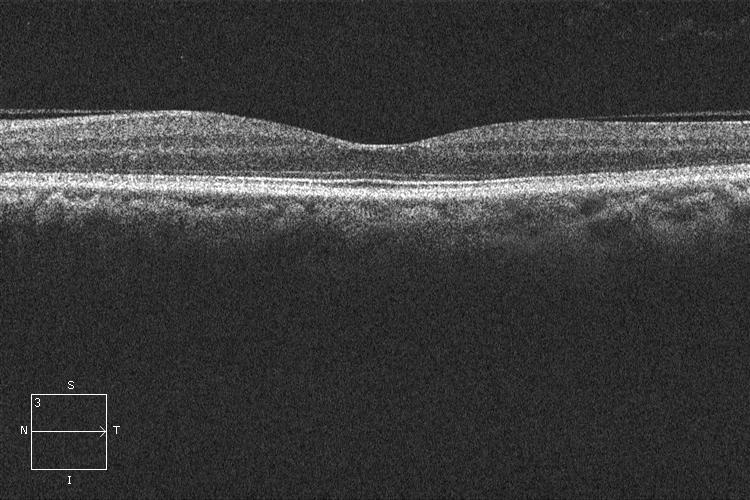

In [0]:
from IPython.display import Image

image_check = 'NORMAL102.jpeg'

Image(image_path+image_check)

In [0]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

./Normal/NORMAL102.jpeg
Input image shape: (1, 224, 224, 3)


In [0]:
preds = model.predict(x)
print('Predicted:', preds)

Predicted: [[0.0835584  0.02587211 0.04437579 0.7384399  0.1077538 ]]


In [0]:
prediction=np.argmax(preds)

if prediction==0:
  print('It\'s AMD')
elif prediction==1:
  print('It\'s Diabetic Retinopathy')
elif prediction==2:
  print('It\'s Macular Hole')
elif prediction==3:
  print('It\'s Normal')
else:
  print('It\'s Serous Retinopathy')

It's Normal


# Making Some Predictions

In [0]:
preds = model.predict(test_dataset, steps=val_steps)

preds = preds.argmax(axis=-1)

In [0]:
# just do the first 32, as validation dataset only has 1 set of 32
test_labels = val_labels_list[0:val_steps*32]

# Make a Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=ply.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    ply.imshow(cm, interpolation='nearest', cmap=cmap)
    ply.title(title)
    ply.colorbar()
    tick_marks = np.arange(len(classes))
    ply.xticks(tick_marks, classes, rotation=45)
    ply.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ply.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ply.tight_layout()
    ply.ylabel('True label')
    ply.xlabel('Predicted label')


Normalized confusion matrix
[[0.9375     0.         0.         0.0625     0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.03333333 0.96666667 0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.03703704 0.         0.         0.96296296]]


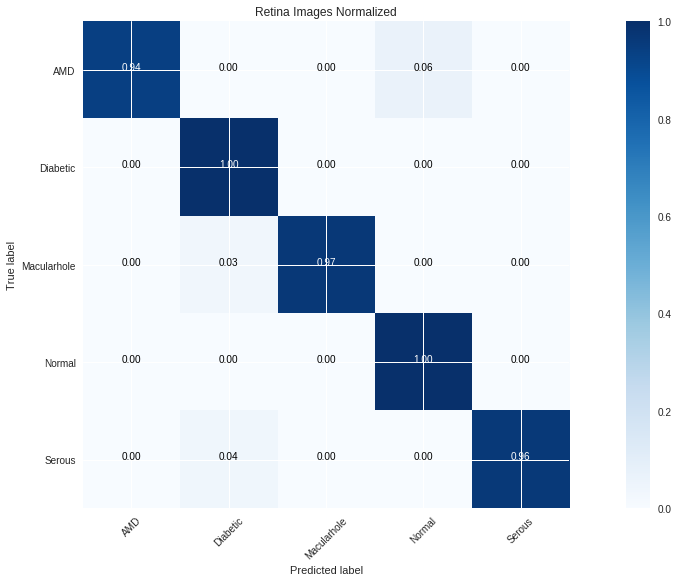

In [0]:
cm_plot_labels = names

# # Plot normalized confusion matrix
ply.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Retina Images Normalized')

ply.show()